In [41]:
from dataGeneration import generateSyntheticData
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [42]:
x_train, y_train, causal, Kva, Kve = generateSyntheticData(seed=1, n=1000, p=800, d=0.005, popNum=1, groupNum=1,
                          noise=0.01, confounderWeight=0)

y_train = y_train.reshape(1, -1)

causal_idx = causal[0: 4, 0: 1]
#causal_idx = causal_idx.reshape(1, -1)
causal_idx = np.reshape(causal_idx, [-1])
print "causal:\n", causal_idx

causal:
[  37.   72.  235.  767.]


In [43]:
n_hidden_1 = 80
n_hidden_2 = 1

learning_rate = 0.005
batch_size = 20
display_step = 1
training_epochs =1000 

n_input = 800
n_class = 1

Alpha = 0.8
keep_p = 0.6

train_loss = np.zeros(training_epochs/batch_size)
train_acc = np.zeros(training_epochs/batch_size)
judge_0 = tf.zeros([n_input], tf.float32) 

In [44]:
diag_random = np.random.normal(0.2, 0.1, n_input)
Ma_diag = np.diag(diag_random)
weight_lasso = tf.cast(tf.Variable(Ma_diag), tf.float32)


x = tf.placeholder(tf.float32, [None, n_input])
y = tf.placeholder(tf.float32, [n_class, None])


bias_lasso = tf.Variable(tf.random_normal([n_input], 0.2, 0.1))
output_lasso = tf.add(tf.matmul(x, weight_lasso), bias_lasso)
layer_0 = tf.nn.relu(output_lasso)

In [45]:
def judge_range(pred, y):
    sub = tf.abs(tf.subtract(pred, y))
    ones = tf.ones([1, batch_size], tf.float32)  
    bel = 1.5
    ones = ones * bel
    #if sub < bel, correct                
    judg = tf.less_equal(sub, ones)
    
    return judg        
        


def add_layer(inputs, a, b, act_Fun = None):
    
    weight = tf.cast(tf.Variable(tf.random_normal([a, b], 0.2, 0.1)), tf.float32)
    bias = tf.Variable(tf.random_normal([b], 0.2, 0.1))
    yy = tf.add(tf.matmul(inputs, weight), bias)
    yy = tf.nn.dropout(yy, keep_p)
    
    if act_Fun is None:
        output = yy        
    else:
        output = act_Fun(yy)
    
    return output

def multiplayer_perceptron(first_in):
    
    layer_1 = add_layer(first_in, n_input, n_hidden_1, act_Fun = tf.nn.relu)
    
    layer_2 = add_layer(layer_1, n_hidden_1, n_hidden_2, act_Fun = tf.nn.relu)
    
    out_layer = add_layer(layer_2, n_hidden_2, n_class, act_Fun = tf.nn.relu) 
    
    return out_layer


In [46]:
pred = multiplayer_perceptron(layer_0)
pred = tf.reshape(pred, [1, batch_size])

weight_lasso_sum = tf.trace(weight_lasso, name = None)
weight_lasso_sum_abs = tf.abs(weight_lasso_sum)

loss = tf.reduce_mean(tf.reduce_sum(tf.square(tf.subtract(y, pred)), [0, 1]) + tf.multiply(Alpha, weight_lasso_sum_abs))  
optimize = tf.train.AdamOptimizer(learning_rate).minimize(loss)

#correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
correct_prediction = judge_range(pred, y)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [55]:
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    
    step = 1
    while step * batch_size - 1 < training_epochs:
        
        x_train_n = x_train[(step - 1)*batch_size: step * batch_size, 0: n_input]
               
        y_train_n = y_train[0, (step - 1)*batch_size: step * batch_size]
        y_train_np = y_train_n.reshape(1, -1)
        
        feed = {x: x_train_n, y: y_train_np}
        
        sess.run(optimize, feed_dict = feed)
        
        dig_tensor = tf.diag_part(weight_lasso, name=None)
        weight_lasso = tf.cast(tf.diag(dig_tensor), tf.float32)
        
        if step % display_step == 0:
            los, acc = sess.run([loss, accuracy], feed_dict = feed)
            
            train_loss[step - 1] = los
            train_acc[step - 1] = acc
            
            print("step: %d  loss: %.9f  TRAIN_ACCURACY: %.3f"  % (step, los, acc))
            
#            a = sess.run(pred, feed_dict = feed)
#            b = y_train_np
#            print a
#            print b
#            print sess.run(weight_lasso)
#            print "**************************"
        if step == training_epochs/batch_size:
            
            q = sess.run(layer_0, feed_dict = feed)
            print "layer_0:\n", q
            print "**************************"
            q_sum_tensor = tf.reduce_sum(layer_0, [0, 1])
            q_sum = sess.run(q_sum_tensor, feed_dict = feed)
            print "layer_0_sum:\n", q_sum
            print "**************************"
            rank_sum_tensor = tf.cast(tf.reduce_sum(layer_0, 0), tf.float32)
 #           rank_sum = sess.run(rank_sum_tensor, feed_dict = feed)
 #           print "rank_sum:\n", rank_sum
 #           print "**************************"
            diff_tensor = tf.setdiff1d(rank_sum_tensor, judge_0, name=None)  
            diff, diff_idx = sess.run(diff_tensor, feed_dict = feed)
            print "diff_idx:\n", diff_idx
            print "**************************"
            p = sess.run(pred, feed_dict = feed)
            print "pred:\n", p
            
            
        step = step + 1
        
    print "完成！！！！！"
    
 

step: 1  loss: 396.975128174  TRAIN_ACCURACY: 0.550
step: 2  loss: 186.833694458  TRAIN_ACCURACY: 0.600
step: 3  loss: 167.028228760  TRAIN_ACCURACY: 0.700
step: 4  loss: 144.506515503  TRAIN_ACCURACY: 0.900
step: 5  loss: 158.638275146  TRAIN_ACCURACY: 0.800
step: 6  loss: 165.557922363  TRAIN_ACCURACY: 0.650
step: 7  loss: 170.637969971  TRAIN_ACCURACY: 0.750
step: 8  loss: 139.845809937  TRAIN_ACCURACY: 0.850
step: 9  loss: 156.577484131  TRAIN_ACCURACY: 0.700
step: 10  loss: 146.772735596  TRAIN_ACCURACY: 0.800
step: 11  loss: 148.200439453  TRAIN_ACCURACY: 0.700
step: 12  loss: 130.411361694  TRAIN_ACCURACY: 0.950
step: 13  loss: 137.704330444  TRAIN_ACCURACY: 0.800
step: 14  loss: 131.863830566  TRAIN_ACCURACY: 0.850
step: 15  loss: 174.865936279  TRAIN_ACCURACY: 0.600
step: 16  loss: 150.324386597  TRAIN_ACCURACY: 0.700
step: 17  loss: 146.493103027  TRAIN_ACCURACY: 0.750
step: 18  loss: 127.654747009  TRAIN_ACCURACY: 0.850
step: 19  loss: 125.115722656  TRAIN_ACCURACY: 0.850
st

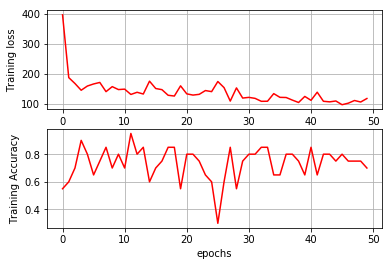

In [56]:
plt.subplot(211)
plt.plot(train_loss, 'r')
plt.xlabel("epochs")
plt.ylabel("Training loss")
plt.grid(True)

plt.subplot(212)
plt.plot(train_acc, 'r')
plt.xlabel("epochs")
plt.ylabel('Training Accuracy')
#plt.ylim(0.0, 1)
plt.grid(True)

plt.show()